# Assignment 3 - Task 2

Group: David, Chrisitan

Goal: Select minimal number of explanations, so that merging them contains all necessary and sufficient information to understand and fix the bug.

## Approach

We have chosen the bug `HIT01_8` for this task. The following explanation serves as our ground truth benchmark:

```
The specification states, that the method "DateTimeZone()" accepts a minutes offset value in the range of -59 to 59 inlcusive. The method checks if this value, stored as "minutesOffset", is within these bounds on line 279, but incorrectly throws an "IllegalArgumentException" for any minutes offset less than zero instead of less than -59. To fix the issue and satisfy the specification, the conditional on line 279 should check for "minutesOffset < -59" instead.
```

### LLM

We use the `deepseek-llm:7b` model, which we query via the `REST-API` provided by locally running the model using `Ollama`.

### Metrics

As our readability and semantic similarity metrics we have chosen the "Flesch reading ease" and "BLEURT" metrics respectively. The former grades how easy an english text is to read on a scale of 0-100, higher scores meaning a text is more easily readable, while the latter is a regression-model-based metric that compares a candidate text to a reference and returns a score that indicates to what extent the candidate is fluent and conveys the meaning of the reference ([bleurt on github](https://github.com/google-research/bleurt)).

Since the Flesch reading ease grades the readability of a given text, and our ground truth represents an acceptable level of readability (subjectively speaking), the readability score of the generated explanation should be at or above this threshold. A score that is significantly above this threshold, i.e. an explanation that is much easier to read than our ground truth, might not be desirable however, since this could indicate a strong deviation from out ground truth.

The BLEURT scoring metric generates scores between 0.0 and 1.0, with higher scores indicating, that the candidate shows higher similarity to the reference, our ground truth in this case. As such a higher BLEURT score would be desirable. We think a threshold of 0.75 might be appropriate.

In [ ]:
import requests
import json
import textstat
import bleurt
import tqdm
import re
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
from bleurt import score

2025-02-09 16:45:16.561819: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 16:45:17.571662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739115918.040355   59059 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739115918.153817   59059 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 16:45:19.241231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
df = pd.read_csv('answerList_data.csv')

# API provided by running llm using Ollama locally
url = "http://localhost:11434/api/generate"
headers = {
    "Content-Type": "application/json"
}
model_deepseek_llm = "deepseek-llm:7b"
model_llama = "llama3.2:3b"
data = {
    "model": model_deepseek_llm,
    "prompt": "",
    "stream": False
}

explanations_df = df[(df['FailingMethod'] == 'HIT01_8') & (df['TP'] == 1)]
ground_truth = 'The specification states, that the method "DateTimeZone()" accepts a minutes offset value in the range of -59 to 59 inlcusive. The method checks if this value, stored as "minutesOffset", is within these bounds on line 279, but incorrectly throws an "IllegalArgumentException" for any minutes offset less than zero instead of less than -59. To fix the issue and satisfy the specification, the conditional on line 279 should check for "minutesOffset < -59" instead.'

## Prompting

We prompt the model to generate an explanation of the failure, including a fix, based on the given explanations. We prompt the model to present the output in valid json.

During each run we increase the number of explanations given to the model.

In [93]:
prompt_task = "###Task:\nYou are a professional software developer. You are given a number of explanations describing the root of cause and possible fix to a software failure. Based on the given explanations, write a single explanation that contains all the information required to understand and fix the bug. The explanation should be succinct and without redundant information"

prompt_input = "### Input:\n\nHere are the failure explanations:\n\n"

prompt_output = "### Output:\nFormat your response in valid JSON format with a single field 'explanation' of type string containing your generated explanation."

In [94]:
def calculateFleschReadingEase(candidate) -> float:
    return textstat.flesch_reading_ease(candidate)

# Calculates BLEURT score of candidate compared to reference
# Requires the BLEURT-20 checkpoint to run
def calculateBleurtScore(references, candidates) -> list:
    scorer = bleurt.score.LengthBatchingBleurtScorer(checkpoint='BLEURT-20')
    bleurt_scores = scorer.score(references=references, candidates=candidates)
    return bleurt_scores

In [96]:
# Calculate readability and BLEURT of original explanations

def calculate_original_metrics(original_df):
    original_id = original_df['Answer.ID'].to_list()
    original_explanations = original_df['Answer.explanation'].to_list()
    explanation_readability = [calculateFleschReadingEase(expl) for expl in original_explanations]
    explanation_bleurt = calculateBleurtScore([ground_truth] * len(original_explanations), original_explanations)
    data = {
        'Answer.ID': original_id,
        'Answer.explanation': original_explanations,
        'Answer.readability': explanation_readability,
        'Answer.bleurt': explanation_bleurt
    }
    return pd.DataFrame(data)

original_explanations_df = calculate_original_metrics(explanations_df)

INFO:tensorflow:Reading checkpoint BLEURT-20.


INFO:tensorflow:Reading checkpoint BLEURT-20.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.


INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:Average batch sequence length: 194.5


INFO:tensorflow:Average batch sequence length: 194.5


In order to choose which explanations we consolidate, we sort by which explanations that pass the readability threshold of `47.12` set by our ground truth have the highest similarity (BLEURT) score.

In [98]:
ground_truth_readability = calculateFleschReadingEase(ground_truth)
original_explanations_df['Answer.readability_threshold'] = original_explanations_df['Answer.readability'] >= ground_truth_readability
explanations_sorted_df = original_explanations_df.sort_values(by=['Answer.readability_threshold', 'Answer.bleurt'], ascending=False)

In [100]:
def generate_explanations(explanations, url, headers, data, prompt_task, prompt_input, prompt_output=''):
    explanation_text = explanations['Answer.explanation'].to_list()
    input = ''
    responses = []

    for expl in tqdm.tqdm(explanation_text):
        input = input + "'''\n" + expl + "\n'''\n\n"
        prompt = prompt_task + prompt_input + input + prompt_output
        data['prompt'] = prompt
        response = requests.post(url, headers=headers, data=json.dumps(data))
        if (response.status_code == 200):
            responses.append({'prompt': prompt, 'result': json.loads(response.text)['response']})
    return responses

In [ ]:
data_llama = data.copy()
data_llama['model'] = model_llama
responses = generate_explanations(explanations_sorted_df, url, headers, data, prompt_task, prompt_input)
responses_llama = generate_explanations(explanations_sorted_df, url, headers, data_llama, prompt_task, prompt_input)

100%|██████████| 31/31 [06:16<00:00, 12.14s/it]


In [101]:
schema = {
    "$schema": "ase-schema",
    "title": "Explanation",
    "description": "A failure explanation",
    "type": "object",
    "properties": {
        "explanation": {
            "description": "The generated explanation",
            "type": "string"
        }
    },
    "required": ["explanation"]
}
# data_json = {
#     "model": model_deepseek_llm,
#     "prompt": "",
#     "stream": False,
#     "format": "json"
# }
data_json = {
    "model": model_deepseek_llm,
    "prompt": "",
    "stream": False,
    "format": schema
}
responses_json = generate_explanations(explanations_sorted_df, url, headers, data_json, prompt_task, prompt_input, prompt_output)

100%|██████████| 31/31 [04:52<00:00,  9.45s/it]


In [102]:
generated_explanations = [json.loads(r['result'])['explanation'] for r in responses_json]
generated_explanations_readability = [calculateFleschReadingEase(expl) for expl in generated_explanations]
generated_explanations_bleurt = calculateBleurtScore([ground_truth] * len(generated_explanations), generated_explanations)
df_data = {
    'generated_explanation': generated_explanations,
    'readability': generated_explanations_readability,
    'bleurt': generated_explanations_bleurt
}
generated_explanations_df = pd.DataFrame(df_data)

INFO:tensorflow:Reading checkpoint BLEURT-20.


INFO:tensorflow:Reading checkpoint BLEURT-20.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Will load checkpoint BLEURT-20


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... name:BLEURT-20


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... max_seq_length:512


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... vocab_file:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... do_lower_case:None


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... sp_model:sent_piece


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:... dynamic_seq_length:True


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Creating SentencePiece tokenizer.


INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.


INFO:tensorflow:Will load model: BLEURT-20/sent_piece.model.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:SentencePiece tokenizer created.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:Average batch sequence length: 181.0


INFO:tensorflow:Average batch sequence length: 181.0


array([<Axes: >, <Axes: >], dtype=object)

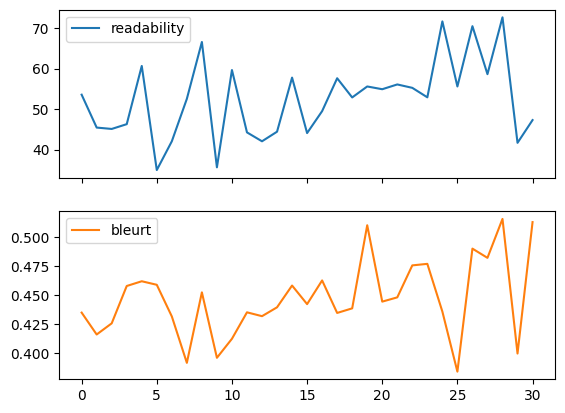

In [103]:
generated_explanations_df.plot(subplots=True)

In [104]:
calculateFleschReadingEase(ground_truth)

47.12

In [105]:
generated_explanations_df.sort_values(by=['bleurt', 'readability'], ascending=False)

,generated_explanation,readability,bleurt
28,The error occurs on line 279 when checking if ...,72.66,0.515562
30,The exception is thrown on line 279 due to the...,47.28,0.512807
19,The code is checking if the value of 'minutesO...,55.58,0.510120
26,The error occurs on line 279 due to the value ...,70.47,0.489959
27,The error is occurring on line 279 because the...,58.62,0.482011
23,The error is occurring on line 279 due to the ...,52.90,0.476840
22,The error is occurring on line 279 due to the ...,55.24,0.475518
16,The given error occurs at line 279 when the mi...,49.49,0.462552
4,The conditional statement on line 279 is check...,60.65,0.461841
5,The given negative minuteOffset value (-15) is...,34.94,0.458791


In [106]:
generated_explanations_df.to_csv('generated_explanations_w_score.csv', encoding='utf-8')

As we can see, none of the generated explanations lie above our previously postulated similarity threshold of `0.75`. The highest BLEURT score being `0.515562`, with a readability of `72.66` that is above our reference threshhold of `47.12`, however. This is the best explanation in terms of our metrics, achieved after combining 29 (indexing starts at 0) original explanations.

A relatively close explanation, in terms of both metrics, was generated with only 20 explanations with a BLEURT score of `0.510120` and a readability of `55.58`.

The generation of consolidated explanations seems not very consistent, however, since combining 5 explanations already yielded a BLEURT score of `0.461841` and a readability of `60.65`, with a lot of generated explanations based on additional input resulting in explanations with lower BLEURT scores, although the gap is relatively small in general.